<center><h1>Example of statistical analysis:</h1>
<h2>Search of gaussian signal in an exponentially decreasing background</h2> 

<h3>1. Tools and functions definitions: </h3>

<h4> loading the tools: </h4>

In [1]:
# Native Python modules
import os, sys, csv, string

# Scipy/Numpy modules
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#get the plots in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<h4>Functions definitions </h4>

In [2]:
def bgFunc(alpha):
    return lambda x: 1.0/alpha*np.exp(-x/alpha)
def sigFunc(mu, sigma):
    return lambda x: 1.0/(np.sqrt(2*np.pi)*sigma)*np.exp(-np.power((x-mu),2)/(2*np.power(sigma,2)))

In [3]:
bg=bgFunc(25)
sg=sigFunc(15,2)

<h4>generate the signal and background histograms</h4>

In [4]:
def generateHisto(xRange,nbBins,func):
    binSize=(xRange[1]-xRange[0])/nbBins
    xBinLow=[]
    xiVal=[]
    xWidth=[]
    #first check which scale should be applied to the histogram
    histoIntegral=0
    for i in range(0,nbBins):
        xi=xRange[0]+1.0*i*binSize+1.0*binSize/2
        histoIntegral=histoIntegral+func(xi)
    #compute the scale to apply to the histo
    reScale=1./histoIntegral
    #now generate the histo
    for i in range(0,nbBins):
        xBinLow.append(xRange[0]+i*binSize)
        xi=xRange[0]+1.0*i*binSize+1.0*binSize/2
        xiVal.append(reScale*func(xi))
        xWidth.append(binSize)
    return [xBinLow, xiVal, xWidth]



sumSig= 1.0 sumBg= 1.0


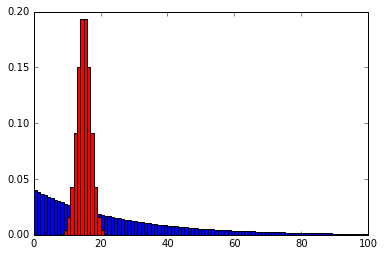

In [5]:
bgHisto_=generateHisto([0,100],100,bg)
sigHisto_=generateHisto([0,100],100,sg)
 
plt.bar(bgHisto_[0], bgHisto_[1], width=bgHisto_[2])     
plt.bar(sigHisto_[0], sigHisto_[1], width=sigHisto_[2],color='r')     

print('sumSig=',sum(sigHisto_[1]), 'sumBg=', sum(bgHisto_[1]))



<Container object of 100 artists>

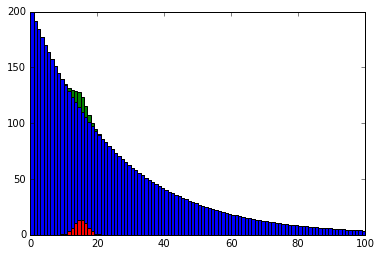

In [6]:
NbBgEvent_=5000
NbSigEvent_=70

sigHistoNormed=[x * NbSigEvent_ for x in sigHisto_[1]]
bgHistoNormed=[x * NbBgEvent_ for x in bgHisto_[1]]


sumSigBg=list(map(add,sigHistoNormed, bgHistoNormed))
plt.bar(sigHisto_[0], sumSigBg, width=sigHisto_[2],color='g')     
plt.bar(bgHisto_[0], bgHistoNormed, width=bgHisto_[2])     
plt.bar(sigHisto_[0], sigHistoNormed, width=sigHisto_[2],color='r')

<h4>loading the data </h4>

In [7]:
dataHist=[183, 203, 189, 178, 169, 187, 156, 150, 164, 141, 153, 123, 122, 122, 117, 128, 125, 99, 91, 93, 85, 100, 91, 64, 80, 66, 69, 65, 64, 59, 64, 58, 55, 47, 52, 36, 54, 47, 53, 42, 34, 40, 45, 40, 32, 40, 24, 29, 30, 28, 19, 27, 23, 26, 23, 22, 28, 20, 13, 16, 13, 15, 15, 20, 18, 12, 13, 11, 13, 10, 9, 16, 10, 13, 6, 8, 13, 14, 4, 4, 9, 3, 10, 10, 8, 6, 11, 9, 6, 4, 6, 4, 9, 3, 5, 10, 5, 5, 5, 4]

<Container object of 100 artists>

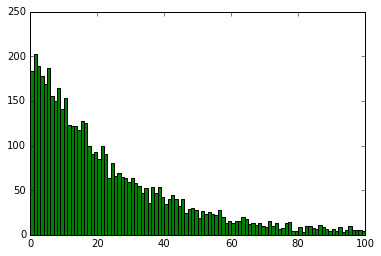

In [8]:
plt.bar(sigHisto_[0], dataHist, width=sigHisto_[2],color='g')  

<h4>Generate pseudo-data</h4>

<Container object of 100 artists>

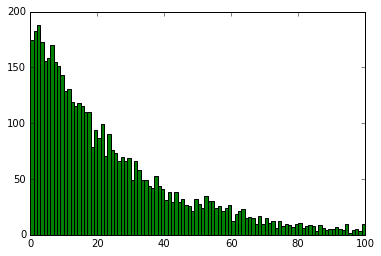

In [9]:
def pseudoDataFromHisto(histoSig,histoBg, NbSigEvent,NbBgEvent, mu):
    smearedHisto=[]
    sigHistoNormed=[x * NbSigEvent* mu for x in histoSig]
    bgHistoNormed=[x * NbBgEvent for x in histoBg]
    theHisto=map(add,sigHistoNormed, bgHistoNormed)
    for aBin in theHisto:
        smearedHisto.append(np.random.poisson(aBin,1)[0])
    return smearedHisto

myPseudoDataTest=pseudoDataFromHisto(sigHisto_[1],bgHisto_[1],NbSigEvent_, NbBgEvent_,1)
plt.bar(sigHisto_[0], myPseudoDataTest, width=sigHisto_[2],color='g')  


<h3>2. Likelyhood ratio</h3>

<h4>Define and compute the likelihood ratio </h4>

$$L_{\mu \times s + b}(data) = \prod_{i \in bins} P_{Poisson}\left(d_{i} | \mu \times s_{i} + b_{i}\right) $$
$$L_{\mu \times s + b}(data) = \prod_{i \in bins} \frac{\left(\mu \times s_{i} + b_{i}\right)^{d_{i}}}{d_{i}!}\times e^{-\left(\mu \times s_{i} + b_{i}\right)} $$
$$\frac{L_{s+b}(data)}{L_{b}(data)} =  \prod_{i \in bins} \frac{\frac{\left( s_{i} + b_{i}\right)^{d_{i}}}{d_{i}!}\times e^{s_{i} + b_{i}}}{\frac{\left(b_{i}\right)^{d_{i}}}{d_{i}!}\times e^{b_{i}}} = \prod_{i \in bins} \left(1+\frac{s_{i}}{b_{i}}\right)^{d_{i}}\times e^{-s_{i}}$$
$$Q=-2\times ln \left(\frac{L_{s+b}(data)}{L_{b}(data)}\right) = 2s - 2\times \sum_{i \in bins} d_{i}\times ln\left(1+\frac{s_{i}}{b_{i}}\right)  $$

In [10]:
def likelyhoodRatio(data,modelSig,modelBg,NbSigEvent,NbBgEvent):
    nbBin=len(data)
    LikelyValue=(NbSigEvent)
    for i in range(0,nbBin):
        LikelyValue=LikelyValue-(data[i]*np.log(1+NbSigEvent*modelSig[i]/(NbBgEvent*modelBg[i])))
    return 2*LikelyValue

valueLikelyhoodRatio=likelyhoodRatio(dataHist,sigHisto_[1],bgHisto_[1],NbSigEvent_, NbBgEvent_)

print(valueLikelyhoodRatio)

-2.70903320646


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


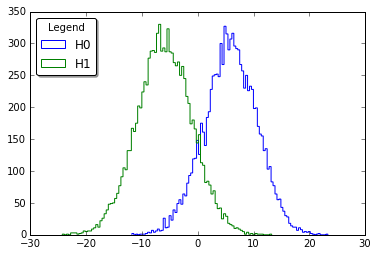

In [12]:
nbToys=10000
LRbgOnly=[]
for i in range(0,nbToys):
    if i%1000==0:
        print(i)
    aPseudoBgOnly=pseudoDataFromHisto(sigHisto_[1],bgHisto_[1],NbSigEvent_, NbBgEvent_,0)
    LRbgOnly.append(likelyhoodRatio(aPseudoBgOnly,sigHisto_[1],bgHisto_[1],NbSigEvent_, NbBgEvent_))
LRbgOnlyHist = plt.hist(LRbgOnly,histtype='step',bins=100,label='H0')

LRsigBg=[]
for i in range(0,nbToys):
    if i%1000==0:
        print(i)
    aPseudoSigBg=pseudoDataFromHisto(sigHisto_[1],bgHisto_[1],NbSigEvent_, NbBgEvent_,1)
    LRsigBg.append(likelyhoodRatio(aPseudoSigBg,sigHisto_[1],bgHisto_[1],NbSigEvent_, NbBgEvent_))
LRsigBgHist = plt.hist(LRsigBg,histtype='step',bins=100,label='H1')
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=1, shadow=True, title="Legend", fancybox=True)

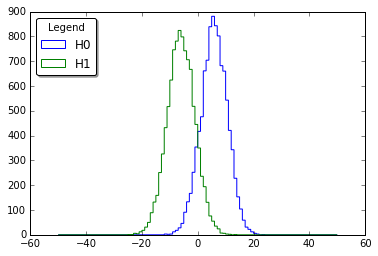

In [13]:
LRbins=[x for x in range(-50,51)]
histoValsBgOnly,LRBins,patchBg = hist(LRbgOnly,LRbins,histtype='step',label='H0')
histoValsSigBg,LRBins,patchSigBg = hist(LRsigBg,LRbins,histtype='step',label='H1')
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=1, shadow=True, title="Legend", fancybox=True)